In this study, we look at how the difference between st22 and the average of the  neighboring stations (st 21 and 23). In this data set, the trolley is directly underneath station 22.
The difference has been made positive (absolute value of the difference)

In [54]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import math

#import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old
import allantools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':10, 'family':'serif'})

def difference(y, avgt):      ##Compresses an array by averaging over the given averaging time to "bin" the data, difference is a misleading name
    t = np.arange(int(avgt) , len(y), int(avgt))
    N = len(t)
    Sum = 0
    avgdiff = np.array([])
    for i in y:
        Sum += i
        if (np.where(y == i)[0][0]% avgt == 0) and (np.where(y == i)[0][0] > 0):
            avg = Sum/avgt
            Sum = 0
            avgdiff = np.append(avgdiff, avg)
            
        
    return (t,avgdiff)

def MovingAvg(x, bin_size):
    i = 0
    avg = np.array([])
    while (i <= len(x) - bin_size):
        Sum = 0
        j = 0
        while (j < bin_size):
            Sum += x[i + j]
            j += 1
        avg = np.append(avg, Sum/bin_size)
        if(i % 86400 == 0):
            print(str(i) + "iterations done")
        i +=1
    return avg
        
def line(x,m,b): #just a line equation
    return m*x + b

def Multiplot(x_data, y_data, height, width, dimension, sublabels = None, x_axis_labels = None, y_axis_labels = None, figname = None, CST = False, daylines = False, day_offset = 0, logscale = False, day_label = ""):
    #x_data is an array containing arrays with the different data to plot
    #y_data ""
    #width is the width of the whole figure in inches
    #height is the height of the whole figure in inches
    #dimension is an array containing the dimensions of the plot figure np.array([3,2])  would correspond to 6 plots (3 rows, 2 cols)
    #x_axis_labels labels is an array containing the labels on the subplots
    #Similarly for y
    #sublabels are the titles are the subplots (1 x n array of strings), can just be 1 x 1 if all the same
    #Figname is the name of the plot
    #CST will convert the x-axis data into CST time
    #Daylines will plot red lines to show days.
    #day_offset in case we want the 24 hour mark to be somewhere else other than just 24 hours from the start
    for i in range(len(x_data)):
        if len(x_data[i]) != len(y_data[i]):
            print("The dimensions of x[" + str(i) + "] and y[" + str(i) + "] do not match")
    
    equal_x_labels = True
    for k in range(len(x_axis_labels)):
        for l in range(len(x_axis_labels)):
            if k != l:
                if  x_axis_labels[k] != x_axis_labels:
                    equal_x_labels = False
                    
    equal_y_labels = True
    for k in range(len(y_axis_labels)):
        for l in range(len(y_axis_labels)):
            if k != l:
                if  y_axis_labels[k] != y_axis_labels:
                    equal_y_labels = False
    day = np.array([86400,86400])
    fig, axs = plt.subplots(dimension[0], dimension[1], constrained_layout=True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            axs[i,j].plot(x_data[dimension[1] * i + j], y_data[dimension[1] * i + j])
            if equal_x_labels:
                axs[i,j].set_xlabel(x_axis_labels[0])
            else:
                axs[i,j].set_xlabel(x_axis_labels[dimension[1] * i + j])
            if equal_y_labels:
                axs[i,j].set_ylabel(y_axis_labels[0])
            else:
                axs[i,j].set_ylabel(y_axis_labels[dimension[1] * i + j])
            axs[i,j].set_title(sublabels[dimension[1] * i + j])
            if daylines:
                days = int((x_data[dimension[1] * i + j].max() - x_data[dimension[1] * i + j].min()) / 86400)
                for n in range(days):
                    axs[i,j].plot(day * (n+1) + day_offset + x_data[dimension[1] * i + j][0], [y_data[dimension[1] * i + j].min(), y_data[dimension[1] * i + j].max()], 'r', label = day_label)
                    axs[i,j].legend()
            if logscale:
                axs[i,j].set_xscale('log')
                axs[i,j].set_yscale('log')
            if CST:
                plt_unix_time_to_CST(axs[i,j])
    fig.suptitle(figname)

def ArrayRound(array, value):
    #For a 1-D array of values that are non-decreasing everywhere. Returns the element of the array closest to the value given
    inf = -1
    sup = -1
    if array[0] >= value:
        return array[0]
    else:
        for number in array:
            if number <= value:
                inf = number
        if inf == value:
            return value
        else:
            sup = array[np.where(array == inf)[0] +1]
            if abs(inf - value) < abs(sup - value):
                return inf
            elif abs(inf-value) > abs(sup - value):
                return sup
            else:
                print("The closest the value provided is exactly in between two elements of the array, the lower element has been returned.")
                return inf
        
    
def DayLineFit(time_data, y_data, start):
    #Fits lines on points 24 hours apart. Assuming the time data is in seconds, takes into account any binning done
    #Assumes time_data points are equally spaced; hence the the difference variable
    step = ArrayRound(time_data, start)
    difference = time_data[1] - time_data[0]
    day = int(round(86400/difference,0))
    slopes = np.array([])
    intercepts = np.array([])
    test = np.array([step, step + (day*difference)])
    while step + 86400 <= time_data[-1]:
        x = np.array([step, step + (day*difference)])
        y = np.array([y_data[np.where(time_data == step)[0]], y_data[np.where(time_data == step + (day*difference))[0]]])
        z = np.polyfit(x,y,1)
        slopes = np.append(slopes, z[0])
        intercepts = np.append(intercepts, z[1])
        step = time_data[np.where(time_data == step)[0][0] +1]
    return slopes, intercepts

def DayParFit(time_data, y_data, start):
    #Fits parabola on points 24 hours apart. Assuming the time data is in seconds, takes into account any binning done
    #Assumes time_data points are equally spaced; hence the the difference variable
    step = ArrayRound(time_data, start)
    difference = time_data[1] - time_data[0]
    day = int(round(86400/difference,0))
    a = np.array([])
    b = np.array([])
    c = np.array([])
    while step + 2*86400 <= time_data[-1]:
        x = np.array([step, step + (day*difference), step + (2*(day*difference))])
        y = np.array([y_data[np.where(time_data == step)[0]], y_data[np.where(time_data == step + (day*difference))[0]], y_data[np.where(time_data == step + (2*(day*difference)))[0]]])
        z = np.polyfit(x,y,2)
        a = np.append(a, z[0])
        b = np.append(b, z[1])
        c = np.append(c, z[2])
        step = time_data[np.where(time_data == step)[0][0] +1]
    return a, b, c

def LogSlope(x,y,a): #Returns the slope of a graph at x = a, a is the actual number, not log of the point of interest.
    figwidth = 13
    figheight = 5
    a = ArrayRound(x,a)
    t = np.where(x == a)[0][0]
    diff_y32 = np.log10(y[t + 1]) - np.log10(y[t])
    diff_x32 = np.log10(x[t + 1]) - np.log10(x[t])
    diff_y21 = np.log10(y[t]) - np.log10(y[t-1])
    diff_x21 = np.log10(x[t]) - np.log10(x[t-1])
    m = (.5*(diff_y32/diff_x32)) + (.5*(diff_y21/diff_x21))
    b = np.log10(y[t]) - m * np.log10(x[t])
    line = (10** b) * (x ** m)
    
    fig, axs = plt.subplots(1, 1, constrained_layout=True)
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    axs.plot(x,y)
    axs.plot(x, line, 'c', label = "y = " + str(np.round(m,2)) + "x + " + str(np.round(b, 2)))
    axs.plot([x[t]], [y[t]],'o', 'k')
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.legend()
    axs.set_ylim(min(y), max(y))
    axs.set_aspect('equal')
    plt.show()
    
def cos(x, A, phi):
    period = 86400
    return A * np.cos(2 * np.pi * x / period  + phi)

def ResSquare(obs, exp):
    s = 0
    if(len(obs)!= len(exp)):
        print("The length of the arrays in the ResSquare function are not equal")
    for i in range(len(obs)):
        s += (obs[i] - exp[i])**2
    return s

def Variance(obs, exp, dof):
    return ResSquare(obs, exp)/dof

def Chi2(obs, exp, variance):
    return ResSquare(obs, exp)/variance

def Ftest(chi21, chi22, nu2):
    return nu2 * (chi21 - chi22) / chi22


def Harmonics(x, y, variance, GuessForAAndPhi = None): #Fitting function with F test included, this is only for Cosine  as of now.
    vars1, cov1 = curve_fit(cos, x, y, GuessForAAndPhi)
    period = 86400
    A = vars1[0]
    phi = vars1[1]
    w = 2 * np.pi /period
    def harm2(x, B):
        return(cos(x, A, phi) + B * np.cos(2*w*x + phi))
    vars2, cov2 = curve_fit(harm2, x, y)
    B = vars2[0]
    chi21 = Chi2(y, cos(x, A, phi), variance)
    chi22 = Chi2(y, harm2(x,B), variance)
    terms = 1
    nu2 = len(x) - terms - 1
    F = Ftest(chi21, chi22, nu2)
    print("F_1,2 = " + str(F) + "would you like to add another term? yes[y], no[n]")
    addTerm = raw_input()
    Y = y - harm2(x,B)
    Amplitudes = np.array([phi,A])
    zeros = np.zeros(len(Y))
    if(addTerm == 'y'):
        Amplitudes = np.append(Amplitudes, B)
        
    while addTerm == 'y':
        terms += 1
        def NewTerm(t, C):
            return C * np.cos((terms + 1) * w * t + phi)
        vars3, cov3 = curve_fit(NewTerm, x, Y)
        C = vars3[0]
        chi21 = Chi2(Y,zeros, variance)
        chi22 = Chi2(Y, NewTerm(x,C), variance)
        nu2 = len(x) - terms - 1
        F = Ftest(chi21, chi22, nu2)
        print("F_" + str(terms) + "," + str(terms + 1) + " = " + str(F) + "would you like to add another term? yes[y], no[n]")
        addTerm = raw_input()
        if (addTerm == 'y'):
            Amplitudes = np.append(Amplitudes, C)
        Y = Y - NewTerm(x, C)
    print("You entered something other than y, no more harmonics added. Last harmonic was number " + str(terms))
    print("All you need is to use the fuction BestFit and enter the coefficient array output by this function. The first coefficient is phi")
    return Amplitudes

def BestFit(x, Amplitudes): #Only use arrays output by the Harmonics function if you are unsure of how this function works. First element is phi, rest are amplitude coeff.
    Coeff = Amplitudes
    period = 86400
    w = 2 * np.pi / period
    phi = Amplitudes[0]
    Sum = Coeff[1] * np.cos(w * x + phi) 
    for i in range(len(Amplitudes) - 2):
        Sum += Coeff[i + 2] * np.cos((i + 2)*w*x + phi)
    return Sum

In [55]:
filename = 'hdf5/superlong_1.h5'
sl_interp_df = pd.read_hdf(filename)
#sl_interp_df.head()

In [56]:
sl_moment_df = helper.calc_moment_df(sl_interp_df)

Finished calculating all moments for 252363 events.               


In [68]:
#Running before remmoval of data points to show the difference in the allan deviations.
T = sl_moment_df.index.to_numpy()
st22m1_list = sl_moment_df["st22,m1"].to_numpy()
st21m1_list = sl_moment_df["st21,m1"].to_numpy()
st23m1_list = sl_moment_df["st23,m1"].to_numpy()

st22m2_list = sl_moment_df["st22,m2"].to_numpy()
st21m2_list = sl_moment_df["st21,m2"].to_numpy()
st23m2_list = sl_moment_df["st23,m2"].to_numpy()

st22m3_list = sl_moment_df["st22,m3"].to_numpy()
st21m3_list = sl_moment_df["st21,m3"].to_numpy()
st23m3_list = sl_moment_df["st23,m3"].to_numpy()

st22m4_list = sl_moment_df["st22,m4"].to_numpy()
st21m4_list = sl_moment_df["st21,m4"].to_numpy()
st23m4_list = sl_moment_df["st23,m4"].to_numpy()

st22m5_list = sl_moment_df["st22,m5"].to_numpy()
st21m5_list = sl_moment_df["st21,m5"].to_numpy()
st23m5_list = sl_moment_df["st23,m5"].to_numpy()

st22m6_list = sl_moment_df["st22,m6"].to_numpy()
st21m6_list = sl_moment_df["st21,m6"].to_numpy()
st23m6_list = sl_moment_df["st23,m6"].to_numpy()

t = np.logspace(0, math.log(len(st22m1_list),10), 200)  # tau values from 1 to length of columns
#station averages
sa1 = (st21m1_list + st23m1_list)/2
sa2 = (st21m2_list + st23m2_list)/2
sa3 = (st21m3_list + st23m3_list)/2
sa4 = (st21m4_list + st23m4_list)/2
sa5 = (st21m5_list + st23m5_list)/2
sa6 = (st21m6_list + st23m6_list)/2
#difference between station average and station 22
ss1 = st22m1_list-sa1 # The m1 measured by the station 22 is higher than the average always
ss2 = st22m2_list-sa2 # The m2 measured by the station 22 is higher than the average always
ss3 = st22m3_list-sa3 # The m3 measured by the station 22 is higher than the average always
ss4 = st22m4_list-sa4 # The m4 measured by the station average is higher than station 22 always
ss5 = st22m5_list-sa5 # The m5 measured by the station average is higher than station 22 always
ss6 = st22m6_list-sa6 # The m6 measured by the station 22 is higher than the average always

t = np.logspace(0, math.log(len(st22m1_list),10), 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(tb1, adb1, ade, adn) = allantools.adev(ss1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(tb2, adb2, ade, adn) = allantools.adev(ss2, rate=r, data_type="freq", taus = t)
(tb3, adb3, ade, adn) = allantools.adev(ss3, rate=r, data_type="freq", taus = t)  
(tb4, adb4, ade, adn) = allantools.adev(ss4, rate=r, data_type="freq", taus = t)
(tb5, adb5, ade, adn) = allantools.adev(ss5, rate=r, data_type="freq", taus = t) 
(tb6, adb6, ade, adn) = allantools.adev(ss6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgtb1 = tb1[np.where(adb1==adb1.min())][0]
avgtb2 = tb2[np.where(adb2==adb2.min())][0]
avgtb3 = tb3[np.where(adb3==adb3.min())][0]
avgtb4 = tb4[np.where(adb4==adb4.min())][0]
avgtb5 = tb5[np.where(adb5==adb5.min())][0]
avgtb6 = tb6[np.where(adb6==adb6.min())][0]

In [69]:
run_start = sl_moment_df.index.values[0] #I forgot to keep the times on arrays, was still getting used to CST time
time_deleted = 61200
sl_moment_df = sl_moment_df.drop(np.arange(run_start, run_start + time_deleted)) #deleting the drift part

In [70]:
T = sl_moment_df.index.to_numpy()
st22m1_list = sl_moment_df["st22,m1"].to_numpy()
st21m1_list = sl_moment_df["st21,m1"].to_numpy()
st23m1_list = sl_moment_df["st23,m1"].to_numpy()

st22m2_list = sl_moment_df["st22,m2"].to_numpy()
st21m2_list = sl_moment_df["st21,m2"].to_numpy()
st23m2_list = sl_moment_df["st23,m2"].to_numpy()

st22m3_list = sl_moment_df["st22,m3"].to_numpy()
st21m3_list = sl_moment_df["st21,m3"].to_numpy()
st23m3_list = sl_moment_df["st23,m3"].to_numpy()

st22m4_list = sl_moment_df["st22,m4"].to_numpy()
st21m4_list = sl_moment_df["st21,m4"].to_numpy()
st23m4_list = sl_moment_df["st23,m4"].to_numpy()

st22m5_list = sl_moment_df["st22,m5"].to_numpy()
st21m5_list = sl_moment_df["st21,m5"].to_numpy()
st23m5_list = sl_moment_df["st23,m5"].to_numpy()

st22m6_list = sl_moment_df["st22,m6"].to_numpy()
st21m6_list = sl_moment_df["st21,m6"].to_numpy()
st23m6_list = sl_moment_df["st23,m6"].to_numpy()

In [71]:
t = np.logspace(0, math.log(len(st22m1_list),10), 50)  # tau values from 1 to length of columns
#station averages
sa1 = (st21m1_list + st23m1_list)/2
sa2 = (st21m2_list + st23m2_list)/2
sa3 = (st21m3_list + st23m3_list)/2
sa4 = (st21m4_list + st23m4_list)/2
sa5 = (st21m5_list + st23m5_list)/2
sa6 = (st21m6_list + st23m6_list)/2
#difference between station average and station 22
ss1 = st22m1_list-sa1 # The m1 measured by the station 22 is higher than the average always
ss2 = st22m2_list-sa2 # The m2 measured by the station 22 is higher than the average always
ss3 = st22m3_list-sa3 # The m3 measured by the station 22 is higher than the average always
ss4 = st22m4_list-sa4 # The m4 measured by the station average is higher than station 22 always
ss5 = st22m5_list-sa5 # The m5 measured by the station average is higher than station 22 always
ss6 = st22m6_list-sa6 # The m6 measured by the station 22 is higher than the average always

In [72]:
t = np.logspace(0, math.log(len(st22m1_list),10), 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(ts1, ads1, ade, adn) = allantools.adev(ss1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(ts2, ads2, ade, adn) = allantools.adev(ss2, rate=r, data_type="freq", taus = t)
(ts3, ads3, ade, adn) = allantools.adev(ss3, rate=r, data_type="freq", taus = t)  
(ts4, ads4, ade, adn) = allantools.adev(ss4, rate=r, data_type="freq", taus = t)
(ts5, ads5, ade, adn) = allantools.adev(ss5, rate=r, data_type="freq", taus = t) 
(ts6, ads6, ade, adn) = allantools.adev(ss6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgts1 = ts1[np.where(ads1==ads1.min())][0]
avgts2 = ts2[np.where(ads2==ads2.min())][0]
avgts3 = ts3[np.where(ads3==ads3.min())][0]
avgts4 = ts4[np.where(ads4==ads4.min())][0]
avgts5 = ts5[np.where(ads5==ads5.min())][0]
avgts6 = ts6[np.where(ads6==ads6.min())][0]

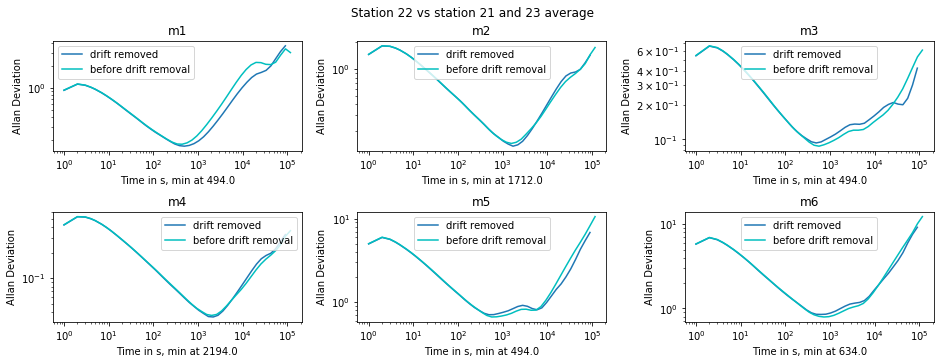

In [26]:
#Plots Allan Deviations:
day  = np.array([86400, 86400])
ads1m = np.array([min(ads1), max(ads1)])         #st22 vs avg
ads2m = np.array([min(ads2), max(ads2)])
ads3m = np.array([min(ads3), max(ads3)])
ads4m = np.array([min(ads4), max(ads4)])
ads5m = np.array([min(ads5), max(ads5)])
ads6m = np.array([min(ads6), max(ads6)])

fig, axs = plt.subplots(2,3, constrained_layout = True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(ts1, ads1, label = "drift removed")
axs[0,0].plot(tb1, adb1, 'c', label = "before drift removal")
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].legend()
axs[0,0].set_xlabel("Time in s, min at " + str(avgts1))
axs[0,0].set_ylabel("Allan Deviation")
axs[0,0].set_title('m1')

axs[0,1].plot(ts2,ads2, label = "drift removed")
axs[0,1].plot(tb2, adb2, 'c', label = "before drift removal")
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend()
axs[0,1].set_xlabel("Time in s, min at " + str(avgts2))
axs[0,1].set_ylabel("Allan Deviation")
axs[0,1].set_title('m2')

axs[0,2].plot(ts3,ads3, label = "drift removed")
axs[0,2].plot(tb3, adb3, 'c', label = "before drift removal")
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].legend()
axs[0,2].set_xlabel("Time in s, min at " + str(avgts3))
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(ts4,ads4, label = "drift removed")
axs[1,0].plot(tb4, adb4, 'c', label = "before drift removal")
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].legend()
axs[1,0].set_xlabel("Time in s, min at " + str(avgts4))
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(ts5,ads5, label = "drift removed")
axs[1,1].plot(tb5, adb5, 'c', label = "before drift removal")
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].legend()
axs[1,1].set_xlabel("Time in s, min at " + str(avgts5))
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(ts6,ads6, label = "drift removed")
axs[1,2].plot(tb6, adb6, 'c', label = "before drift removal")
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].legend()
axs[1,2].set_xlabel("Time in s, min at " + str(avgts6))
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs station 21 and 23 average")

plt.show()

In [27]:
#Fitting a line to the unbinned data (Correlation)
vars1, cov1 = curve_fit(line,st22m1_list, sa1)
print("m = " + str(vars1[0]) + " +- " + str(cov1[0]))
vars2, cov2 = curve_fit(line,st22m2_list, sa2)
print("m = " + str(vars2[0]) + " +- " + str(cov2[0]))
vars3, cov3 = curve_fit(line,st22m3_list, sa3)
print("m = " + str(vars3[0]) + " +- " + str(cov3[0]))
vars4, cov4 = curve_fit(line,st22m4_list, sa4)
print("m = " + str(vars4[0]) + " +- " + str(cov4[0]))
vars5, cov5 = curve_fit(line,st22m5_list, sa5)
print("m = " + str(vars5[0]) + " +- " + str(cov5[0]))
vars6, cov6 = curve_fit(line,st22m6_list, sa6)
print("m = " + str(vars6[0]) + " +- " + str(cov6[0]))

m = 0.9519259739317241 +- [ 4.93345549e-09 -2.50969539e-04]
m = 0.5154713630142712 +- [3.10299742e-06 3.69893852e-03]
m = 0.47064650403380404 +- [5.67401201e-06 2.42832079e-03]
m = 0.38786039895479707 +- [2.70736512e-06 4.60874310e-03]
m = 0.2729421828833537 +- [5.66748337e-05 1.91989254e-01]
m = 0.23226157312764792 +- [6.11718790e-05 2.63974499e-02]


Text(0.5,0.98,'station 22 and st21&23 average')

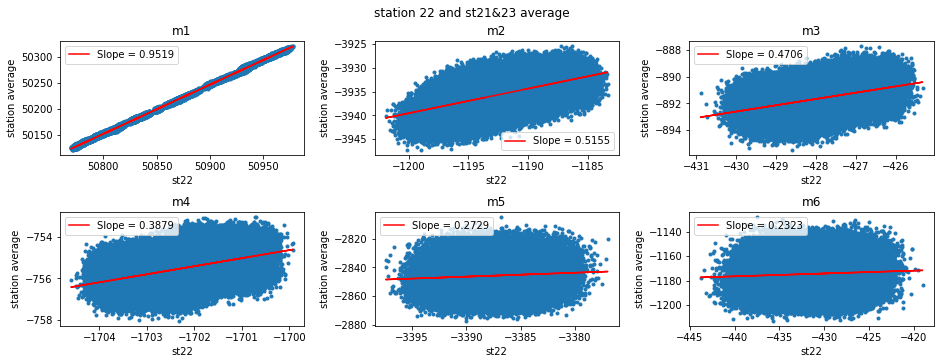

In [28]:
#Plotting the data and the line of best fit
fig, axs = plt.subplots(2,3, constrained_layout = True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(st22m1_list, sa1,'.')
axs[0,0].plot(st22m1_list, line(st22m1_list, *vars1), 'r', label = "Slope = " + str(round(vars1[0], 4)))
axs[0,0].set_xlabel("st22")
axs[0,0].set_ylabel("station average")
axs[0,0].set_title("m1")
axs[0,0].legend()

axs[0,1].plot(st22m2_list, sa2,'.')
axs[0,1].plot(st22m2_list, line(st22m2_list, *vars2), 'r', label = "Slope = " + str(round(vars2[0], 4)))
axs[0,1].set_xlabel("st22")
axs[0,1].set_ylabel("station average")
axs[0,1].set_title("m2")
axs[0,1].legend()

axs[0,2].plot(st22m3_list, sa3,'.')
axs[0,2].plot(st22m3_list, line(st22m3_list, *vars3), 'r', label = "Slope = " + str(round(vars3[0], 4)))
axs[0,2].set_xlabel("st22")
axs[0,2].set_ylabel("station average")
axs[0,2].set_title("m3")
axs[0,2].legend()

axs[1,0].plot(st22m4_list, sa4,'.')
axs[1,0].plot(st22m4_list, line(st22m4_list, *vars4), 'r', label = "Slope = " + str(round(vars4[0], 4)))
axs[1,0].set_xlabel("st22")
axs[1,0].set_ylabel("station average")
axs[1,0].set_title("m4")
axs[1,0].legend()

axs[1,1].plot(st22m5_list, sa5,'.')
axs[1,1].plot(st22m5_list, line(st22m5_list, *vars5), 'r', label = "Slope = " + str(round(vars5[0], 4)))
axs[1,1].set_xlabel("st22")
axs[1,1].set_ylabel("station average")
axs[1,1].set_title("m5")
axs[1,1].legend()

axs[1,2].plot(st22m6_list, sa6,'.')
axs[1,2].plot(st22m6_list, line(st22m6_list, *vars6), 'r', label = "Slope = " + str(round(vars6[0], 4)))
axs[1,2].set_xlabel("st22")
axs[1,2].set_ylabel("station average")
axs[1,2].set_title("m6")
axs[1,2].legend()

fig.suptitle("station 22 and st21&23 average")

In [61]:
#Binning data
#(Tss1_safe, Dss1) =  difference(ss1,avgts1)
#print("1 run(s) done")
#(Tss2_safe, Dss2) =  difference(ss2,avgts2)
#print("2 run(s) done")
#(Tss3_safe, Dss3) =  difference(ss3,avgts3)
#print("3 run(s) done")
#(Tss4_safe, Dss4) =  difference(ss4,avgts4)
#print("4 run(s) done")
#(Tss5_safe, Dss5) =  difference(ss5,avgts5)
#print("5 run(s) done")
#(Tss6_safe, Dss6) =  difference(ss6,avgts6)
#print("6 run(s) done")

deletes = np.linspace(0, 7198, 7199)
deletes = deletes.astype(int)
Tss1_safe = np.delete(T, deletes)
Tss1_safe = Tss1_safe - 7200 + (7200-1) * .5
Tss2_safe = Tss1_safe 
Tss3_safe = Tss1_safe 
Tss4_safe = Tss1_safe 
Tss5_safe = Tss1_safe 
Tss6_safe = Tss1_safe 

Dss1 = MovingAvg(ss1, 7200)
print("m1 done")
print("Length of binned difference is" + str(len(Dss1)))
Dss2 = MovingAvg(ss2, 7200)
print("m2 done")
Dss3 = MovingAvg(ss3, 7200)
print("m3 done")
Dss4 = MovingAvg(ss4, 7200)
print("m4 done")
Dss5 = MovingAvg(ss5, 7200)
print("m5 done")
Dss6 = MovingAvg(ss6, 7200)
print("m6 done")

0iterations done
86400iterations done
172800iterations done
m1 done
Length of binned difference is245164
0iterations done
86400iterations done
172800iterations done
m2 done
0iterations done
86400iterations done
172800iterations done
m3 done
0iterations done
86400iterations done
172800iterations done
m4 done
0iterations done
86400iterations done
172800iterations done
m5 done
0iterations done
86400iterations done
172800iterations done
m6 done


In [62]:
Tss1_safe = np.delete(T, deletes)
Tss1_safe = Tss1_safe - 7200 + (7200-1) * .5
Tss2_safe = Tss1_safe 
Tss3_safe = Tss1_safe 
Tss4_safe = Tss1_safe 
Tss5_safe = Tss1_safe 
Tss6_safe = Tss1_safe 

In [63]:
#The time was set to start at 0 in the allan deviation plots, we must add back the starting time
Tss1 = Tss1_safe #+ run_start + time_deleted
Tss2 = Tss2_safe #+ run_start + time_deleted
Tss3 = Tss3_safe #+ run_start + time_deleted
Tss4 = Tss4_safe #+ run_start + time_deleted
Tss5 = Tss5_safe #+ run_start + time_deleted
Tss6 = Tss6_safe #+ run_start + time_deleted

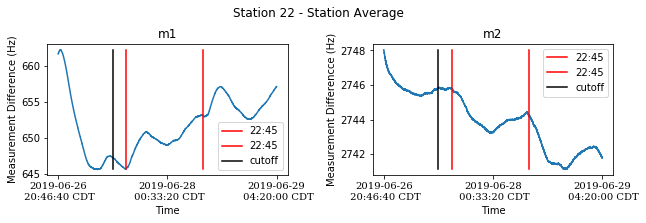

In [65]:
#Plotting data
day = np.array([86400, 86400])
lss1 = min(Dss1) #station to station average
hss1 = max(Dss1)
lss2 = min(Dss2)
hss2 = max(Dss2)
lss3 = min(Dss3)
hss3 = max(Dss3)
lss4 = min(Dss4)
hss4 = max(Dss4)
lss5 = min(Dss5)
hss5 = max(Dss5)
lss6 = min(Dss6)
hss6 = max(Dss6)

fig, axs = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(3)
fig.set_figwidth(9)

axs[0].plot(Tss1, Dss1)
#axs[0,0].plot(Tss1, Dss1, '.')
axs[0].plot(day - 6400 + run_start, [lss1,hss1], 'r', 2*day - 6400 + run_start, [lss1,hss1], 'r', label = "22:45")
axs[0].plot([Tss1[0] + 61200, Tss1[0] + 61200], [lss1,hss1], 'k', label = "cutoff")
axs[0].legend()
plt_unix_time_to_CST(axs[0])
axs[0].set_xlabel("Time")
axs[0].set_xticks([Tss1[0], Tss1[len(Tss1)/2], Tss1[-1]])
axs[0].set_ylabel("Measurement Difference (Hz)")
axs[0].set_title('m1')

axs[1].plot(Tss2, Dss2)
#axs[0,1].plot(Tss2, Dss2, '.')
axs[1].plot(day - 6400 + run_start, [lss2,hss2], 'r', 2*day - 6400 + run_start, [lss2,hss2], 'r', label = "22:45")
axs[1].plot([Tss2[0] + 61200, Tss2[0] + 61200], [lss2,hss2], 'k', label = "cutoff")
axs[1].legend()
plt_unix_time_to_CST(axs[1])
axs[1].set_xlabel("Time")
axs[1].set_xticks([Tss2[0], Tss2[len(Tss2)/2], Tss2[-1]])
axs[1].set_ylabel("Measurement Differencce (Hz)")
axs[1].set_title('m2')
"""
axs[0,2].plot(Tss3, Dss3)
#axs[0,2].plot(Tss3, Dss3, '.')
axs[0,2].plot(day - 6400 + run_start, [lss3,hss3], 'r', 2*day - 6400 + run_start, [lss3,hss3], 'r', label = "22:45")
#axs[0,2].plot([Tss3[0] + 61200, Tss3[0] + 61200], [lss3,hss3], 'k', label = "cutoff")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([Tss3[0], Tss3[len(Tss3)/2], Tss3[-1]])
axs[0,2].set_ylabel("Measurement Differencce (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tss4, Dss4)
#axs[1,0].plot(Tss4, Dss4, '.')
axs[1,0].plot(day - 6400 + run_start, [lss4,hss4], 'r', 2*day - 6400 + run_start, [lss4,hss4], 'r', label = "22:45")
#axs[1,0].plot([Tss4[0] + 61200, Tss4[0] + 61200], [lss4,hss4], 'k', label = "cutoff")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([Tss4[0], Tss4[len(Tss4)/2], Tss4[-1]])
axs[1,0].set_ylabel("Measurement Differencce (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tss5, Dss5)
#axs[1,1].plot(Tss5, Dss5, '.')
axs[1,1].plot(day - 6400 + run_start, [lss5,hss5], 'r', 2*day - 6400 + run_start, [lss5,hss5], 'r', label = "22:45")
#axs[1,1].plot([Tss5[0] + 61200, Tss5[0] + 61200], [lss5,hss5], 'k', label = "cutoff")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([Tss5[0], Tss5[len(Tss5)/2], Tss5[-1]])
axs[1,1].set_ylabel("Measurement Differencce (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tss6, Dss6)
#axs[1,2].plot(Tss6, Dss6, '.')
axs[1,2].plot(day - 6400 + run_start, [lss6,hss6], 'r', 2*day - 6400 + run_start, [lss6,hss6], 'r', label = "22:45")
#axs[1,2].plot([Tss6[0] + 61200, Tss6[0] + 61200], [lss6,hss6], 'k', label = "cutoff")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([Tss6[0], Tss6[len(Tss6)/2], Tss6[-1]])
axs[1,2].set_ylabel("Measurement Differencce (Hz)")
axs[1,2].set_title('m6')
"""
fig.suptitle("Station 22 - Station Average")
plt.show()

#plt.plot(Tss1,Dss1,".")
#plt.plot([86400, 86400], [l1, h1], "r")
#plt.plot([86400*2, 86400*2], [l1, h1], "r")
#plt.title("st22m1 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss2,Dss2,".")
#plt.plot([86400, 86400], [l2, h2], "r")
#plt.plot([86400*2, 86400*2], [l2, h2], "r")
#plt.title("st22m2 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss3,Dss3,".")
#plt.plot([86400, 86400], [l3, h3], "r")
#plt.plot([86400*2, 86400*2], [l3, h3], "r")
#plt.title("st22m3 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss4,Dss4,".")
#plt.plot([86400, 86400], [l4, h4], "r")
#plt.plot([86400*2, 86400*2], [l4, h4], "r")
#plt.title("st22m4 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss5,Dss5,".")
#plt.plot([86400, 86400], [l5, h5], "r")
#plt.plot([86400*2, 86400*2], [l5, h5], "r")
#plt.title("st22m5 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss6,Dss6,".")
#plt.plot([86400, 86400], [l6, h6], "r")
#plt.plot([86400*2, 86400*2], [l6, h6], "r")
#plt.title("st22m6 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

In [33]:
start1 = Tss1[0]
start2 = Tss2[0]
start3 = Tss3[0]
start4 = Tss4[0]
start5 = Tss5[0]
start6 = Tss6[0]

slopes1, intercepts1 = DayLineFit(T, ss1, start1)
slope_avg1 = np.average(slopes1)
intercept_avg1 = np.average(intercepts1)

slopes2, intercepts2 = DayLineFit(T, ss2, start2)
slope_avg2 = np.average(slopes2)
intercept_avg2 = np.average(intercepts2)

slopes3, intercepts3 = DayLineFit(T, ss3, start3)
slope_avg3 = np.average(slopes3)
intercept_avg3 = np.average(intercepts3)

slopes4, intercepts4 = DayLineFit(T, ss4, start4)
slope_avg4 = np.average(slopes4)
intercept_avg4 = np.average(intercepts4)

slopes5, intercepts5 = DayLineFit(T, ss5, start5)
slope_avg5 = np.average(slopes5)
intercept_avg5 = np.average(intercepts5)

slopes6, intercepts6 = DayLineFit(T, ss6, start6)
slope_avg6 = np.average(slopes6)
intercept_avg6 = np.average(intercepts6)

z1 = np.polyfit(Tss1, Dss1, 1)
z2 = np.polyfit(Tss2, Dss2, 1)
z3 = np.polyfit(Tss3, Dss3, 1)
z4 = np.polyfit(Tss4, Dss4, 1)
z5 = np.polyfit(Tss5, Dss5, 1)
z6 = np.polyfit(Tss6, Dss6, 1)

The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.


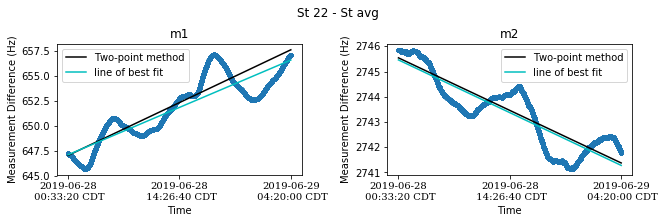

In [41]:
time_deleted = 61200
l1 = Dss1.min()            #st avg vs st 22
h1 = Dss1.max()
l2 = Dss2.min()
h2 = Dss2.max()
l3 = Dss3.min()
h3 = Dss3.max()
l4 = Dss4.min()
h4 = Dss4.max()
l5 = Dss5.min()
h5 = Dss5.max()
l6 = Dss6.min()
h6 = Dss6.max()

fig, axs = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(3)
fig.set_figwidth(9)

#axs[0,0].plot(T1 , D1)
axs[0].plot(Tss1 , Dss1, '.')
#axs[0,0].plot(day-6400-time_deleted + run_start, [l1,h1], 'r', 2*day-6400-time_deleted + run_start, [l1,h1], 'r', label = "22:45")
axs[0].plot(Tss1, line(Tss1, np.average(slopes1), np.average(intercepts1)), 'k', label = "Two-point method")
axs[0].plot(Tss1, line(Tss1, z1[0], z1[1]), "c", label = "line of best fit")
axs[0].legend()
plt_unix_time_to_CST(axs[0])
axs[0].set_xlabel("Time")
axs[0].set_xticks([Tss1[0], Tss1[len(Tss1)/2], Tss1[-1]])
axs[0].set_ylabel("Measurement Difference (Hz)")
axs[0].set_title('m1')#

#axs[0,1].plot(T2 , D2)
axs[1].plot(Tss2 , Dss2, '.')
#axs[0,1].plot(day-6400-time_deleted + run_start, [l2,h2], 'r', 2*day-6400-time_deleted + run_start, [l2,h2], 'r', label = "22:45")
axs[1].plot(Tss2, line(Tss2, np.average(slopes2), np.average(intercepts2)), 'k', label = "Two-point method")
axs[1].plot(Tss2, line(Tss2, z2[0], z2[1]), "c", label = "line of best fit")
axs[1].legend()
plt_unix_time_to_CST(axs[1])
axs[1].set_xlabel("Time")
axs[1].set_xticks([Tss2[0], Tss2[len(Tss2)/2], Tss2[-1]])
axs[1].set_ylabel("Measurement Difference (Hz)")
axs[1].set_title('m2')
"""
#axs[0,2].plot(T3 , D3)
axs[0,2].plot(Tss3 , Dss3, '.')
#axs[0,2].plot(day-6400-time_deleted + run_start, [l3,h3], 'r', 2*day-6400-time_deleted + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].plot(Tss3, line(Tss3, np.average(slopes3), np.average(intercepts3)), 'k', label = "Two-point method")
axs[0,2].plot(Tss3, line(Tss3, z3[0], z3[1]), "c", label = "line of best fit")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([Tss3[0], Tss3[len(Tss3)/2], Tss3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

#axs[1,0].plot(T4 , D4)
axs[1,0].plot(Tss4 , Dss4, '.')
#axs[1,0].plot(day-6400-time_deleted + run_start, [l4,h4], 'r', 2*day-6400-time_deleted + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].plot(Tss4, line(Tss4, np.average(slopes4), np.average(intercepts4)), 'k', label = "Two-point method")
axs[1,0].plot(Tss4, line(Tss4, z4[0], z4[1]), "c", label = "line of best fit")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([Tss4[0], Tss4[len(Tss4)/2], Tss4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

#axs[1,1].plot(T5 , D5)
axs[1,1].plot(Tss5 , Dss5, '.')
#axs[1,1].plot(day-6400-time_deleted + run_start, [l5,h5], 'r', 2*day-6400-time_deleted + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].plot(Tss5, line(Tss5, np.average(slopes5), np.average(intercepts5)), 'k', label = "Two-point method")
axs[1,1].plot(Tss5, line(Tss5, z5[0], z5[1]), "c", label = "line of best fit")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([Tss5[0], Tss5[len(Tss5)/2], Tss5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

#axs[1,2].plot(T6 , D6)
axs[1,2].plot(Tss6 , Dss6, '.')
#axs[1,2].plot(day-6400-time_deleted + run_start, [l6,h6], 'r', 2*day-6400-time_deleted + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].plot(Tss6, line(Tss6, np.average(slopes6), np.average(intercepts6)), 'k', label = "Two-point method")
axs[1,2].plot(Tss6, line(Tss6, z6[0], z6[1]), "c", label = "line of best fit")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([Tss6[0], Tss6[len(Tss6)/2], Tss6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
"""
fig.suptitle("St 22 - St avg")
plt.show()

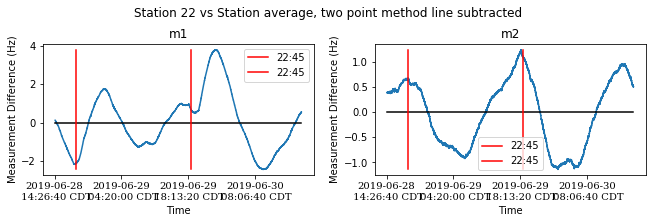

In [42]:
l1 = np.min(Dss1 - line(Tss1, z1[0], z1[1]))            #Trolley vs st 22 line of best fit subtracted.
h1 = np.max(Dss1 - line(Tss1, z1[0], z1[1]))
l2 = np.min(Dss2 - line(Tss2, z2[0], z2[1]))
h2 = np.max(Dss2 - line(Tss2, z2[0], z2[1]))
l3 = np.min(Dss3 - line(Tss3, z3[0], z3[1]))
h3 = np.max(Dss3 - line(Tss3, z3[0], z3[1]))
l4 = np.min(Dss4 - line(Tss4, z4[0], z4[1]))
h4 = np.max(Dss4 - line(Tss4, z4[0], z4[1]))
l5 = np.min(Dss5 - line(Tss5, z5[0], z5[1]))
h5 = np.max(Dss5 - line(Tss5, z5[0], z5[1]))
l6 = np.min(Dss6 - line(Tss6, z6[0], z6[1]))
h6 = np.max(Dss6 - line(Tss6, z6[0], z6[1]))

fig, axs = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(3)
fig.set_figwidth(9)

axs[0].plot(Tss1, Dss1 - line(Tss1, z1[0], z1[1]))
axs[0].plot([Tss1.min(), Tss1.max()], [0,0], 'k')
#axs[0,0].plot(T1 , D1, '.')
axs[0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r', label = "22:45")
axs[0].legend()
plt_unix_time_to_CST(axs[0])
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Measurement Difference (Hz)")
axs[0].set_title('m1')

axs[1].plot(Tss2, Dss2 - line(Tss2, z2[0], z2[1]))
axs[1].plot([Tss2.min(), Tss2.max()], [0,0], 'k')
#axs[0,1].plot(T2 , D2, '.')
axs[1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r', label = "22:45")
axs[1].legend()
plt_unix_time_to_CST(axs[1])
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Measurement Difference (Hz)")
axs[1].set_title('m2')
"""
axs[0,2].plot(Tss3, Dss3 - line(Tss3, z3[0], z3[1]))
axs[0,2].plot([Tss3.min(), Tss3.max()], [0,0], 'k')
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tss4, Dss4 - line(Tss4, z4[0], z4[1]))
axs[1,0].plot([Tss4.min(), Tss4.max()], [0,0], 'k')
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tss5, Dss5 - line(Tss5, z5[0], z5[1]))
axs[1,1].plot([Tss5.min(), Tss5.max()], [0,0], 'k')
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tss6, Dss6 - line(Tss6, z6[0], z6[1]))
axs[1,2].plot([Tss6.min(), Tss6.max()], [0,0], 'k')
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
"""
fig.suptitle("Station 22 vs Station average, two point method line subtracted")
plt.show()


In [38]:
corr_diff1 = ss1 - np.polyval([slope_avg1, intercept_avg1], T)
vars1, cov1 = curve_fit(cos, T, corr_diff1)
print(vars1)

corr_diff2 = ss2 - np.polyval([slope_avg2, intercept_avg2], T)
vars2, cov2 = curve_fit(cos, T, corr_diff2, [.4, 43200])
print(vars2)

corr_diff3 = ss3 - np.polyval([slope_avg3, intercept_avg3], T)
vars3, cov3 = curve_fit(cos, T, corr_diff3)
print(vars3)

corr_diff4 = ss4 - np.polyval([slope_avg4, intercept_avg4], T)
vars4, cov4 = curve_fit(cos, T, corr_diff4)
print(vars4)

corr_diff5 = ss5 - np.polyval([slope_avg5, intercept_avg5], T)
vars5, cov5 = curve_fit(cos, T, corr_diff5)
print(vars5)

corr_diff6 = ss6 - np.polyval([slope_avg6, intercept_avg6], T)
vars6, cov6 = curve_fit(cos, T, corr_diff6)
print(vars6)

A1 = vars1[0]
phi1 = vars1[1]

A2 = vars2[0]
phi2 = vars2[1]

A3 = vars3[0]
phi3 = vars3[1]

A4 = vars4[0]
phi4 = vars4[1]

A5 = vars5[0]
phi5 = vars5[1]

A6 = vars6[0]
phi6 = vars6[1]

[ 1.72550192 -1.14558578]
[-8.73299163e-01  4.32006535e+04]
[-0.18414795  1.21693523]
[-0.16969506  0.79424515]
[-1.21533405  2.01892022]
[ 3.39562884 -1.16009013]


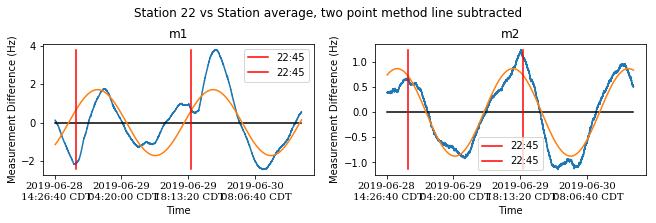

The phase difference is -6875.7798681777485 seconds


In [53]:
l1 = np.min(Dss1 - line(Tss1, z1[0], z1[1]))            #Trolley vs st 22 line of best fit subtracted.
h1 = np.max(Dss1 - line(Tss1, z1[0], z1[1]))
l2 = np.min(Dss2 - line(Tss2, z2[0], z2[1]))
h2 = np.max(Dss2 - line(Tss2, z2[0], z2[1]))
l3 = np.min(Dss3 - line(Tss3, z3[0], z3[1]))
h3 = np.max(Dss3 - line(Tss3, z3[0], z3[1]))
l4 = np.min(Dss4 - line(Tss4, z4[0], z4[1]))
h4 = np.max(Dss4 - line(Tss4, z4[0], z4[1]))
l5 = np.min(Dss5 - line(Tss5, z5[0], z5[1]))
h5 = np.max(Dss5 - line(Tss5, z5[0], z5[1]))
l6 = np.min(Dss6 - line(Tss6, z6[0], z6[1]))
h6 = np.max(Dss6 - line(Tss6, z6[0], z6[1]))

fig, axs = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(3)
fig.set_figwidth(9)

axs[0].plot(Tss1, Dss1 - line(Tss1, z1[0], z1[1]))
axs[0].plot([Tss1.min(), Tss1.max()], [0,0], 'k')
axs[0].plot(Tss1, cos(Tss1, A1, phi1))
#axs[0,0].plot(T1 , D1, '.')
axs[0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r', label = "22:45")
axs[0].legend()
plt_unix_time_to_CST(axs[0])
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Measurement Difference (Hz)")
axs[0].set_title('m1')

axs[1].plot(Tss2, Dss2 - line(Tss2, z2[0], z2[1]))
axs[1].plot([Tss2.min(), Tss2.max()], [0,0], 'k')
axs[1].plot(Tss2, cos(Tss2, A2, phi2))
#axs[0,1].plot(T2 , D2, '.')
axs[1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r', label = "22:45")
axs[1].legend()
plt_unix_time_to_CST(axs[1])
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Measurement Difference (Hz)")
axs[1].set_title('m2')
"""
axs[0,2].plot(Tss3, Dss3 - line(Tss3, z3[0], z3[1]))
axs[0,2].plot([Tss3.min(), Tss3.max()], [0,0], 'k')
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tss4, Dss4 - line(Tss4, z4[0], z4[1]))
axs[1,0].plot([Tss4.min(), Tss4.max()], [0,0], 'k')
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tss5, Dss5 - line(Tss5, z5[0], z5[1]))
axs[1,1].plot([Tss5.min(), Tss5.max()], [0,0], 'k')
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tss6, Dss6 - line(Tss6, z6[0], z6[1]))
axs[1,2].plot([Tss6.min(), Tss6.max()], [0,0], 'k')
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
"""
fig.suptitle("Station 22 vs Station average, two point method line subtracted")
plt.show()
print("The phase difference is " + str((phi1- phi2)/(2 * np.pi)) + " seconds")

In [46]:
yy1 = Dss1 - line(Tss1, slope_avg1, intercept_avg1)
yy2 = Dss2 - line(Tss2, slope_avg2, intercept_avg2)
yy3 = Dss3 - line(Tss3, slope_avg3, intercept_avg3)
yy4 = Dss4 - line(Tss4, slope_avg4, intercept_avg4)
yy5 = Dss5 - line(Tss5, slope_avg5, intercept_avg5)
yy6 = Dss6 - line(Tss6, slope_avg6, intercept_avg6)

In [47]:
#estimating the variance by taking a chunk of data and making red. chi2 = 1
sample_vals = np.array([])
sample_t = np.array([])
for i in range(15000):
    sample_vals = np.append(sample_vals, corr_diff1[i])
    sample_t    = np.append(sample_t , i)
    
fit = np.polyfit(sample_t, sample_vals, 2)
dof = len(sample_vals) - 3
variance1 = Variance(sample_vals, np.polyval(fit, sample_t), dof)
print(variance1)
print(np.sqrt(variance1))

##Now m2
sample_vals = np.array([])
sample_t = np.array([])
for i in range(15000):
    sample_vals = np.append(sample_vals, corr_diff2[i])
    sample_t    = np.append(sample_t , i)
    
fit = np.polyfit(sample_t, sample_vals, 2)
dof = len(sample_vals) - 3
variance2 = Variance(sample_vals, np.polyval(fit, sample_t), dof)
print(variance2)
print(np.sqrt(variance2))


2.4331170746948043
1.5598452085687233
6.817691184978039
2.6110708885394205


In [48]:
m1 = yy1
print("m1 done")
m2 = yy2
print("m2 done")
m3 = yy3
print("m3 done")
m4 = yy4
print("m4 done")
m5 = yy5
print("m5 done")
m6 = yy6
print("m6 done")

m1 done
m2 done
m3 done
m4 done
m5 done
m6 done


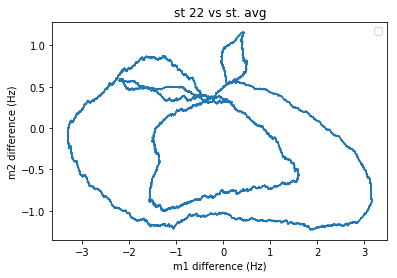

The phase difference is -43201.79904313562


In [49]:
plt.plot(m1, m2,)
#plt.plot(harm1, harm2, label = "Fit")
plt.xlabel("m1 difference (Hz)")
plt.ylabel("m2 difference (Hz)")
plt.title("st 22 vs st. avg")
plt.legend()
plt.show()

print("The phase difference is " + str(phi1 - phi2))

In [ ]:
#ax^2 + bx + c

a1, b1, c1 = DayParFit(Tss1, Dss1, start1)
#print("a1 = " + str(a1))
#print("b1 = " + str(b1))
#print("c1 = " + str(c1))
print(len(c1))
a1 = np.average(a1)
b1 = np.average(b1)
c1 = np.average(c1)

a2, b2, c2 = DayParFit(Tss2, Dss2, start2)
#print("a2 = " + str(a2))
#print("b2 = " + str(b2))
#print("c2 = " + str(c2))
print(len(c2))
a2 = np.average(a2)
b2 = np.average(b2)
c2 = np.average(c2)

a3, b3, c3 = DayParFit(Tss3, Dss3, start3)
#print("a3 = " + str(a3))
#print("b3 = " + str(b3))
#print("c3 = " + str(c3))
print(len(c3))
a3 = np.average(a3)
b3 = np.average(b3)
c3 = np.average(c3)

a4, b4, c4 = DayParFit(Tss4, Dss4, start4)
#print("a4 = " + str(a4))
#print("b4 = " + str(b4))
#print("c4 = " + str(c4))
print(len(c4))
a4 = np.average(a4)
b4 = np.average(b4)
c4 = np.average(c4)

a5, b5, c5 = DayParFit(Tss5, Dss5, start5)
#print("a5 = " + str(a5))
#print("b5 = " + str(b5))
#print("c5 = " + str(c5))
print(len(c5))
a5 = np.average(a5)
b5 = np.average(b5)
c5 = np.average(c5)

a6, b6, c6 = DayParFit(Tss6, Dss6, start6)
#print("a6 = " + str(a6))
#print("b6 = " + str(b6))
#print("c6 = " + str(c6))
print(len(c6))
a6 = np.average(a6)
b6 = np.average(b6)
c6 = np.average(c6)


#Ax^2 + Bx + C
A1, B1, C1 = np.polyfit(Tss1, Dss1, 2)
A2, B2, C2 = np.polyfit(Tss2, Dss2, 2)
A3, B3, C3 = np.polyfit(Tss3, Dss3, 2)
A4, B4, C4 = np.polyfit(Tss4, Dss4, 2)
A5, B5, C5 = np.polyfit(Tss5, Dss5, 2)
A6, B6, C6 = np.polyfit(Tss6, Dss6, 2)

print("A1 = " + str(A1))
print("B1 = " + str(B1))
print("C1 = " + str(C1))

print("A2 = " + str(A2))
print("B2 = " + str(B2))
print("C2 = " + str(C2))

print("A3 = " + str(A3))
print("B3 = " + str(B3))
print("C3 = " + str(C3))

print("A4 = " + str(A4))
print("B4 = " + str(B4))
print("C4 = " + str(C4))

print("A5 = " + str(A5))
print("B5 = " + str(B5))
print("C5 = " + str(C5))

print("A6 = " + str(A6))
print("B6 = " + str(B6))
print("C6 = " + str(C6))

In [ ]:
l1 = Dss1.min()            #Trolley vs st avg
h1 = Dss1.max()
l2 = Dss2.min()
h2 = Dss2.max()
l3 = Dss3.min()
h3 = Dss3.max()
l4 = Dss4.min()
h4 = Dss4.max()
l5 = Dss5.min()
h5 = Dss5.max()
l6 = Dss6.min()
h6 = Dss6.max()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

#axs[0,0].plot(T1 , D1)
axs[0,0].plot(Tss1 , Dss1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r')#, label = "22:45")
axs[0,0].plot(Tss1, np.polyval(np.array([a1, b1, c1]), Tss1), 'k', label = "Three-point method")
axs[0,0].plot(Tss1, np.polyval(np.array([A1, B1, C1]), Tss1), "c", label = "Parabola of best fit")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1, 36 parabolas')#

#axs[0,1].plot(T2 , D2)
axs[0,1].plot(Tss2 , Dss2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r')#, label = "22:45")
axs[0,1].plot(Tss2, np.polyval(np.array([a2, b2, c2]), Tss2), 'k', label = "Three-point method")
axs[0,1].plot(Tss2, np.polyval(np.array([A2, B2, C2]), Tss2), "c", label = "Parabola of best fit")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2, 13 parabolas')

#axs[0,2].plot(T3 , D3)
axs[0,2].plot(Tss3 , Dss3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r')#, label = "22:45")
axs[0,2].plot(Tss3, np.polyval(np.array([a3, b3, c3]), Tss3), 'k', label = "Three-point method")
axs[0,2].plot(Tss3, np.polyval(np.array([A3, B3, C3]), Tss3), "c", label = "Parabola of best fit")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3, 36 parabolas')

#axs[1,0].plot(T4 , D4)
axs[1,0].plot(Tss4 , Dss4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r')#, label = "22:45")
axs[1,0].plot(Tss4, np.polyval(np.array([a4, b4, c4]), Tss4), 'k', label = "Three-point method")
axs[1,0].plot(Tss4, np.polyval(np.array([A4, B4, C4]), Tss4), "c", label = "Parabola of best fit")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4, 13 parabolas')

#axs[1,1].plot(T5 , D5)
axs[1,1].plot(Tss5 , Dss5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r')#, label = "22:45")
axs[1,1].plot(Tss5, np.polyval(np.array([a5, b5, c5]), Tss5), 'k', label = "Three-point method")
axs[1,1].plot(Tss5, np.polyval(np.array([A5, B5, C5]), Tss5), "c", label = "Parabola of best fit")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5, 36 parabolas')

#axs[1,2].plot(T6 , D6)
axs[1,2].plot(Tss6 , Dss6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r')#, label = "22:45")
axs[1,2].plot(Tss6, np.polyval(np.array([a6, b6, c6]), Tss6), 'k', label = "Three-point method")
axs[1,2].plot(Tss6, np.polyval(np.array([A6, B6, C6]), Tss6), "c", label = "Parabola of best fit")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6, 22 parabolas')
fig.suptitle("Station 22 vs st avg")
plt.show()

In [ ]:
l1 = np.min(Dss1 - np.polyval([A1, B1, C1], Tss1))            #Trolley vs st 22 parabola of best fit subtracted.
h1 = np.max(Dss1 - np.polyval([A1, B1, C1], Tss1))
l2 = np.min(Dss2 - np.polyval([A2, B2, C2], Tss2))
h2 = np.max(Dss2 - np.polyval([A2, B2, C2], Tss2))
l3 = np.min(Dss3 - np.polyval([A3, B3, C3], Tss3))
h3 = np.max(Dss3 - np.polyval([A3, B3, C3], Tss3))
l4 = np.min(Dss4 - np.polyval([A4, B4, C4], Tss4))
h4 = np.max(Dss4 - np.polyval([A4, B4, C4], Tss4))
l5 = np.min(Dss5 - np.polyval([A5, B5, C5], Tss5))
h5 = np.max(Dss5 - np.polyval([A5, B5, C5], Tss5))
l6 = np.min(Dss6 - np.polyval([A6, B6, C6], Tss6))
h6 = np.max(Dss6 - np.polyval([A6, B6, C6], Tss6))

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

axs[0,0].plot(Tss1, Dss1 - np.polyval([A1, B1, C1], Tss1))
axs[0,0].plot([Tss1.min(), Tss1.max()], [0,0], 'k')
#axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r', label = "22:45")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(Tss2, Dss2 - np.polyval([A2, B2, C2], Tss2))
axs[0,1].plot([Tss2.min(), Tss2.max()], [0,0], 'k')
#axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r', label = "22:45")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(Tss3, Dss3 - np.polyval([A3, B3, C3], Tss3))
axs[0,2].plot([Tss3.min(), Tss3.max()], [0,0], 'k')
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tss4, Dss4 - np.polyval([A4, B4, C4], Tss4))
axs[1,0].plot([Tss4.min(), Tss4.max()], [0,0], 'k')
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tss5, Dss5 - np.polyval([A5, B5, C5], Tss5))
axs[1,1].plot([Tss5.min(), Tss5.max()], [0,0], 'k')
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tss6, Dss6 - np.polyval([A6, B6, C6], Tss6))
axs[1,2].plot([Tss6.min(), Tss6.max()], [0,0], 'k')
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs st avg - quad fit")
plt.show()

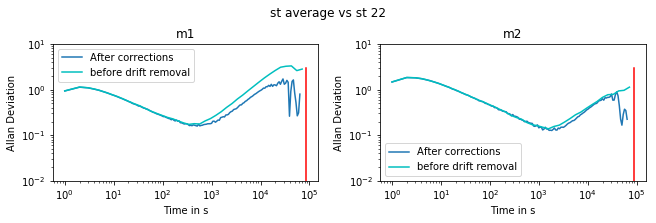

In [73]:
T = sl_moment_df.index.to_numpy() - (run_start + 61200)
t = np.logspace(0, math.log(len(st22m1_list),10), num = 200)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(t1, ad1, ade, adn) = allantools.adev(ss1 - np.polyval([slope_avg1, intercept_avg1], T), rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(t2, ad2, ade, adn) = allantools.adev(ss2 - np.polyval([slope_avg2, intercept_avg2], T), rate=r, data_type="freq", taus = t)
(t3, ad3, ade, adn) = allantools.adev(ss3 - np.polyval([slope_avg3, intercept_avg3], T), rate=r, data_type="freq", taus = t)  
(t4, ad4, ade, adn) = allantools.adev(ss4 - np.polyval([slope_avg4, intercept_avg4], T), rate=r, data_type="freq", taus = t)
(t5, ad5, ade, adn) = allantools.adev(ss5 - np.polyval([slope_avg5, intercept_avg5], T), rate=r, data_type="freq", taus = t) 
(t6, ad6, ade, adn) = allantools.adev(ss6 - np.polyval([slope_avg6, intercept_avg6], T), rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgt1 = t1[np.where(ad1==ad1.min())][0]
avgt2 = t2[np.where(ad2==ad2.min())][0]
avgt3 = t3[np.where(ad3==ad3.min())][0]
avgt4 = t4[np.where(ad4==ad4.min())][0]
avgt5 = t5[np.where(ad5==ad5.min())][0]
avgt6 = t6[np.where(ad6==ad6.min())][0]

#Plots Allan Deviation
day  = np.array([86400, 86400])
ad1m = np.array([min(ad1), max(ad1)])
ad2m = np.array([min(ad2), max(ad2)])
ad3m = np.array([min(ad3), max(ad3)])
ad4m = np.array([min(ad4), max(ad4)])
ad5m = np.array([min(ad5), max(ad5)])
ad6m = np.array([min(ad6), max(ad6)])

fig, axs = plt.subplots(1, 2, constrained_layout=True) #This is St22 vs Trolley
fig.set_figheight(3)
fig.set_figwidth(9)
axs[0].plot(t1, ad1, label = "After corrections")
axs[0].plot(tb1, adb1, 'c', label = "before drift removal")
axs[0].plot([86400,86400],[.01,3], 'r')
axs[0].set_xscale('log')
axs[0].set_ylim(.01,10)                                                                          
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_xlabel("Time in s")
axs[0].set_ylabel("Allan Deviation")
axs[0].set_title('m1')

axs[1].plot(t2,ad2, label = "After corrections")
axs[1].plot(tb2,adb2, 'c', label = "before drift removal")
axs[1].plot([86400,86400],[.01,3], 'r')
axs[1].set_ylim(.01,10)                                                                          
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("Time in s")
axs[1].set_ylabel("Allan Deviation")
axs[1].set_title('m2')
"""
axs[0,2].plot(t3,ad3, label = "After corrections")
axs[0,2].plot(tb3,adb3, 'c', label = "before drift removal")
axs[0,2].plot([86400,86400],[.01,3], 'r')
axs[0,2].set_ylim(.01,10)                                                                          
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].legend()
axs[0,2].set_xlabel("Time in s")
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(t4,ad4, label = "After corrections")
axs[1,0].plot(tb4,adb4, 'c', label = "before drift removal")
axs[1,0].plot([86400,86400],[.01,3], 'r')
axs[1,0].set_ylim(.01,10)                                                                          
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].legend()
axs[1,0].set_xlabel("Time in s")
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(t5,ad5, label = "After corrections")
axs[1,1].plot(tb5,adb5, 'c', label = "before drift removal")
axs[1,1].plot([86400,86400],[.01,3], 'r')
axs[1,1].set_ylim(.01,10)                                                                          
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].legend()
axs[1,1].set_xlabel("Time in s")
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(t6,ad6, label = "After corrections")
axs[1,2].plot(tb6,adb6, 'c', label = "before drift removal")
axs[1,2].plot([86400,86400],[.01,3], 'r')
axs[1,2].set_ylim(.01,10)                                                                          
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].legend()
axs[1,2].set_xlabel("Time in s")
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')
"""
fig.suptitle("st average vs st 22")

plt.show()

In [14]:
test = np.linspace(1,10,10)
print(MovingAvg(test,1))
print(MovingAvg(test,2))
print(MovingAvg(test,3))
print(MovingAvg(test,4))

0iterations done
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
0iterations done
[1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
0iterations done
[2. 3. 4. 5. 6. 7. 8. 9.]
0iterations done
[2.5 3.5 4.5 5.5 6.5 7.5 8.5]


In [19]:
test = np.array([1,2,3,4,5])
print(np.delete(test, -1))
deletes = np.linspace(-7300, -1, 7300)
deletes = deletes.astype(int)
print(np.delete(deletes, test))

[1 2 3 4]
[-7300 -7294 -7293 ...    -3    -2    -1]
